In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pylab as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
random_state = 666

Read Data

In [4]:
import datetime
df = pd.read_csv(
    "newtest.csv", 
)
df = df.dropna()

Label Hospital Name

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['hos'] = le.fit_transform(df['hos'].values)

In [6]:
list(le.classes_)

['井上病院', '岡山', '東京', '横浜', '福大', '聖マリア病院', '関西', '高松']

calculate date

In [7]:
df["date"] = pd.to_datetime(df.loc[:,["year","month","day"]])

add dayofweek

In [8]:
df["day_of_week"] = df["date"].dt.dayofweek

In [9]:
df["week_number"] = df["date"].dt.week

In [10]:
df.head()

,hos,year,month,day,pre_avg_loc,pre_avg_sea,rain,temp_avg,temp_high,temp_low,...,wind_avg,wind_max,wind_max_ins,sun,pre_high,pre_low,px,date,day_of_week,week_number
0,0,2014,1,4,1014.8,1015.1,0.0,6.3,13.2,1.7,...,1.7,4.6,8.5,3.6,1018.0,1012.6,0,2014-01-04,5,1
1,0,2014,1,5,1020.2,1020.5,0.0,5.2,9.0,2.1,...,1.7,3.2,7.4,7.5,1022.3,1018.2,0,2014-01-05,6,1
2,0,2014,1,6,1025.3,1025.7,0.0,4.2,9.9,0.2,...,1.3,3.3,5.7,5.5,1028.0,1021.3,0,2014-01-06,0,2
3,0,2014,1,7,1025.9,1026.3,0.0,4.8,9.9,-0.9,...,1.3,3.3,5.0,6.8,1028.7,1022.8,0,2014-01-07,1,2
4,0,2014,1,8,1015.2,1015.5,13.0,6.8,9.3,4.8,...,1.3,2.8,4.6,0.0,1022.3,1009.1,0,2014-01-08,2,2


---

# Check Data 

病院ごとの発病率

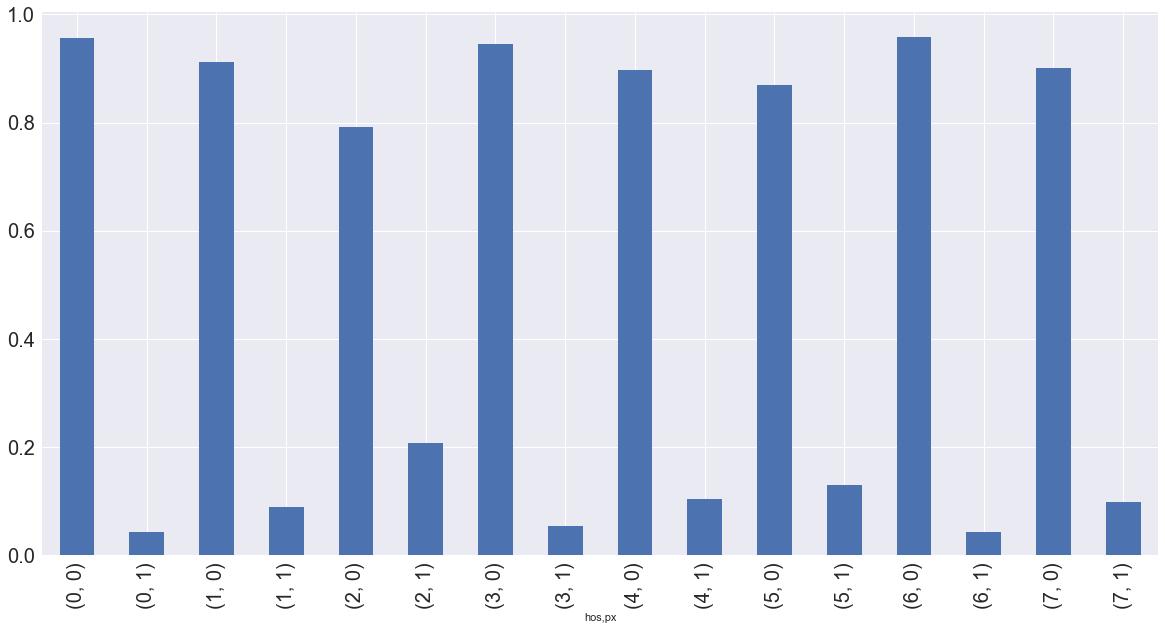

In [11]:
df.groupby("hos")["px"].value_counts(normalize=True).plot(kind="bar", figsize=(20,10), fontsize=20)

2(東京)の発病率が高い ⇒ **地域と相関性があるかも？**

月ごとの発病率

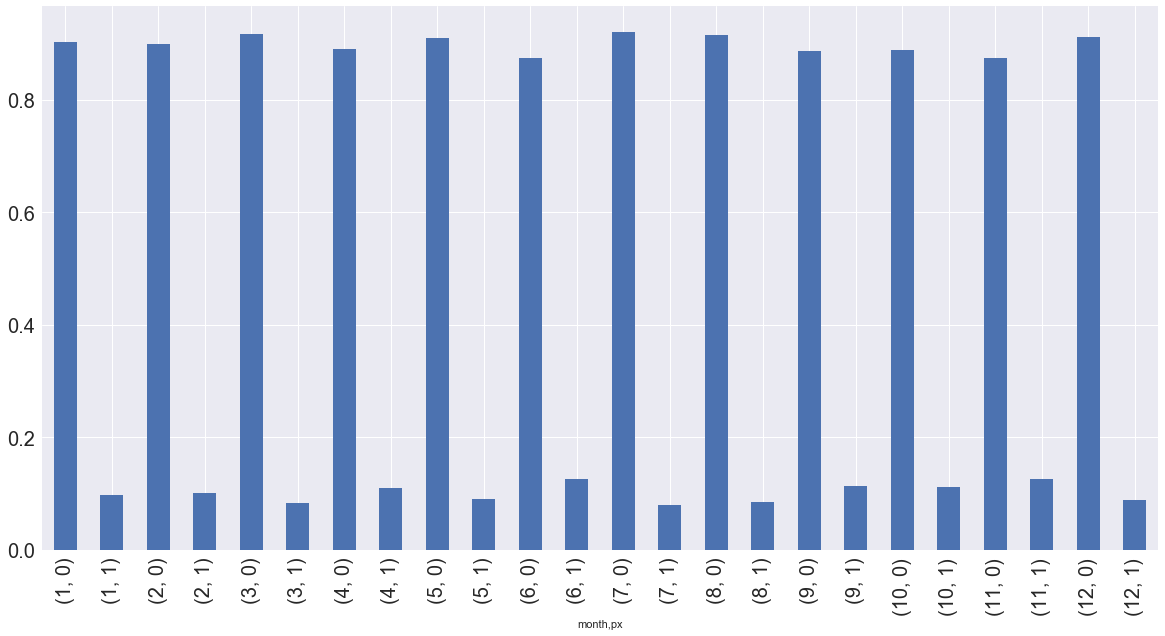

In [12]:
df.groupby("month")["px"].value_counts(normalize=True).plot(kind="bar", figsize=(20,10), fontsize=20)

年ごとの発病率

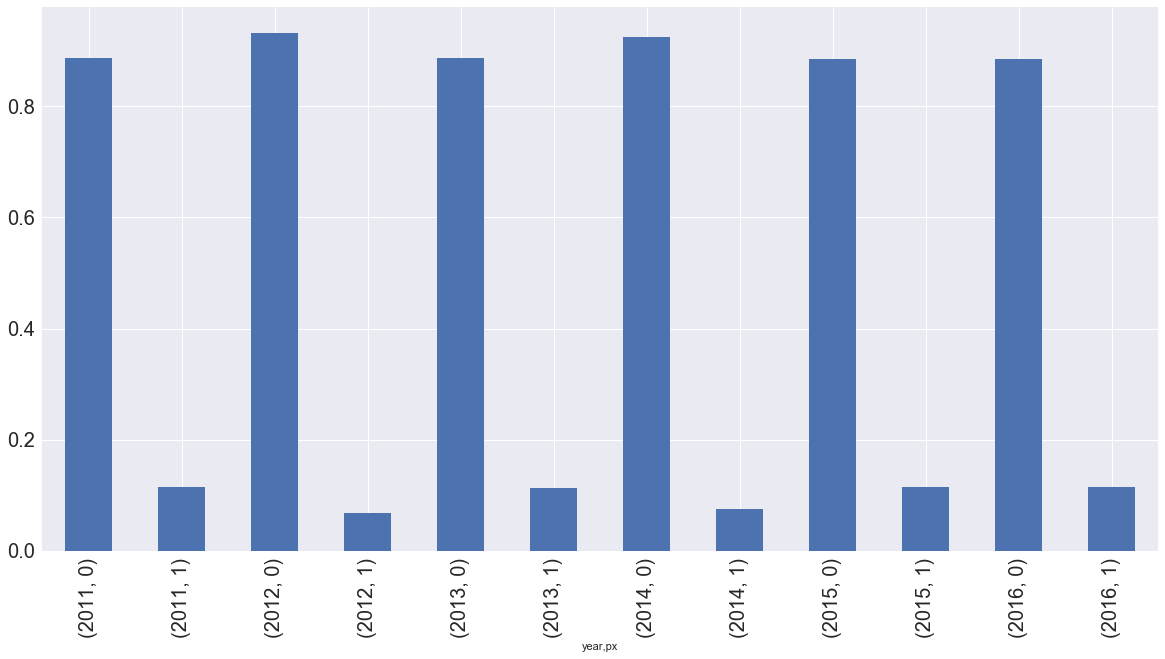

In [13]:
df.groupby("year")["px"].value_counts(normalize=True).plot(kind="bar", figsize=(20,10), fontsize=20)

週ごとの発病率

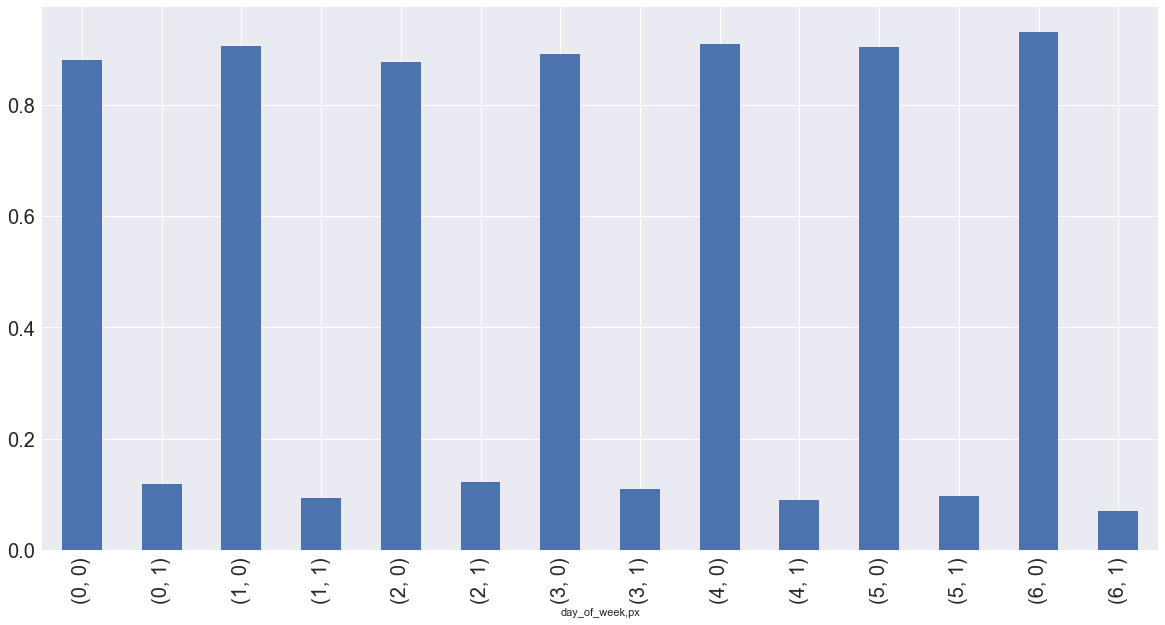

In [14]:
df.groupby("day_of_week")["px"].value_counts(normalize=True).plot(kind="bar", figsize=(20,10), fontsize=20)

---

東京病院の発病数と日付の関係

In [15]:
df_01 = df[df.hos==2]
df_01.index = df_01["date"]

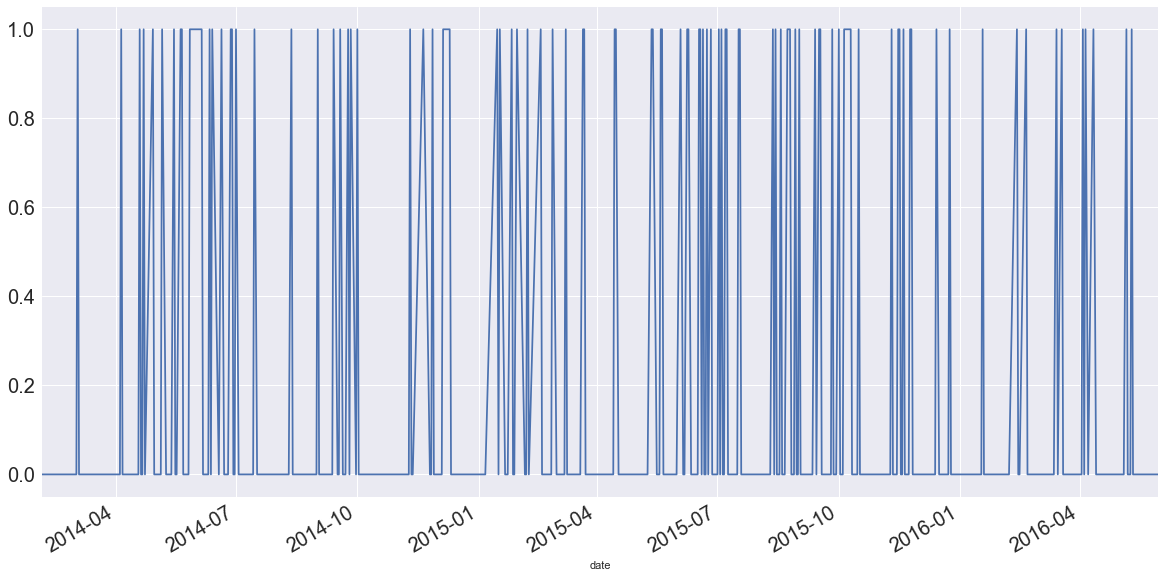

In [16]:
df_01["px"].plot(figsize=(20,10), fontsize=20)

---

## Plan1
- 日付ごとに、発病数の合計を計算する

In [17]:
df2 = df.groupby("date", as_index=False)["px"].sum()

for i in df.columns[(df.columns!="px") & (df.columns!="hos") & (df.columns!="date")]:
    tmp = df.groupby("date", as_index=False)[i].mean()
    df2 = pd.merge(df2, tmp, how='left', on=['date']) 

In [18]:
df2["px"].value_counts()

0     1508
1      448
2       99
3        8
4        2
23       1
17       1
7        1
Name: px, dtype: int64

target: [0,1,2]

In [19]:
df2.loc[df2["px"]>2,"px"] = 2

- 週間集計結果も要因とする
    - 気圧の平均、最大、最小
    - 気温の平均、最大、最小
    - 湿度の平均、最小

In [20]:
tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['pre_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["min_pre_low"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['pre_high'].max()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["max_pre_high"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['pre_avg_loc'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["mean_pre_avg_loc"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['temp_high'].max()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["max_temp_high"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['temp_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["min_temp_low"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['temp_avg'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["mean_temp_avg"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['hum_avg'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["mean_hum_avg"] = np.array(tmplist)[:len(df2)]

tmp = df2.groupby([pd.Grouper(freq='W', key='date')])['hum_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df2["min_hum_low"] = np.array(tmplist)[:len(df2)]

In [21]:
df2.head()

,date,px,year,month,day,pre_avg_loc,pre_avg_sea,rain,temp_avg,temp_high,...,day_of_week,week_number,min_pre_low,max_pre_high,mean_pre_avg_loc,max_temp_high,min_temp_low,mean_temp_avg,mean_hum_avg,min_hum_low
0,2011-04-04,0,2011,4,4,1016.4,1020.5,0.0,10.3,17.1,...,0,14,1011.8,1023.5,1017.271429,22.1,4.5,13.942857,53.428571,13.0
1,2011-04-05,0,2011,4,5,1019.8,1023.8,0.0,12.1,21.0,...,1,14,1011.8,1023.5,1017.271429,22.1,4.5,13.942857,53.428571,13.0
2,2011-04-06,0,2011,4,6,1021.2,1025.2,0.0,14.3,22.1,...,2,14,1011.8,1023.5,1017.271429,22.1,4.5,13.942857,53.428571,13.0
3,2011-04-07,1,2011,4,7,1018.4,1022.3,0.0,17.3,21.9,...,3,14,1011.8,1023.5,1017.271429,22.1,4.5,13.942857,53.428571,13.0
4,2011-04-08,0,2011,4,8,1014.0,1018.0,24.0,14.9,16.4,...,4,14,1011.8,1023.5,1017.271429,22.1,4.5,13.942857,53.428571,13.0


**RandomForest解析では、"year"の影響が大きいことがわかりました。
yearごとにデータ分布が不均衡のため、削除します。**

In [22]:
df2 = df2.drop(["date","year"],axis=1)

In [23]:
X = df2.drop("px",axis=1)
y = df2["px"]

要因：月、日、現地気圧、海面気圧、降水量、平均気温、最高気温、最低気温、平均湿度、最低湿度、平均風速、最大風速、瞬間最大風速、日照時間、最高気圧、最低気圧、週、週番号、週間最低気圧、週間最高気圧、週間平均気圧、週間最高気温、週間最低気温、週間平均気温、週間平均湿度、週間最低湿度

In [24]:
X.columns

Index(['month', 'day', 'pre_avg_loc', 'pre_avg_sea', 'rain', 'temp_avg',
       'temp_high', 'temp_low', 'hum_avg', 'hum_low', 'wind_avg', 'wind_max',
       'wind_max_ins', 'sun', 'pre_high', 'pre_low', 'day_of_week',
       'week_number', 'min_pre_low', 'max_pre_high', 'mean_pre_avg_loc',
       'max_temp_high', 'min_temp_low', 'mean_temp_avg', 'mean_hum_avg',
       'min_hum_low'],
      dtype='object')

学習、検証データ

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=random_state)

xgboost + GridSearch

In [26]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = lgb.LGBMRegressor(learning_rate=0.05)

model_cv = GridSearchCV(model, {'min_child_weight':[0.001,0.01,0.0001],'subsample_freq':[1,3,5],'reg_alpha':[0.0,0.1,0.3],'reg_lambda':[0.0,0.1,0.3]}, verbose=1)
model_cv.fit(X_train, y_train)
print(model_cv.best_params_)

"""params = {
    'random_state': random_state,
    'colsample_bytree': 1, 
    'min_child_samples': 10, 
    'num_leaves': 50, 
    'subsample': 0.5
}"""

model = lgb.LGBMRegressor(**model_cv.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'min_child_weight': 0.001, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample_freq': 1}


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:    3.7s finished


MSE:

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.30778732928712316

In [28]:
result = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})

真の値ごとに、予測値の平均値を計算

In [29]:
result.groupby(['actual']).mean()

,pred
actual,
0,0.299063
1,0.366202
2,0.461288


In [30]:
# result.to_csv('result.csv', index=False)

In [31]:
result["actual"].value_counts()

0    302
1     88
2     24
Name: actual, dtype: int64

- 独立2標本t検定(Welch's t-test)
    - サイズ違う⇒対応なし
    - 分散違う⇒Welch's t-test
    - 2標本：発病ありと発病なし

In [32]:
from scipy import stats
stats.ttest_ind(result[result["actual"]==0]["pred"].values, result[(result["actual"]==1) | (result["actual"]==2)]["pred"].values, equal_var=False)

Ttest_indResult(statistic=-5.0587523496657232, pvalue=1.0890990635429646e-06)

有意差あり

- 3標本一元配置

In [33]:
stats.f_oneway(result[result["actual"]==0]["pred"].values, result[result["actual"]==1]["pred"].values, result[result["actual"]==2]["pred"].values)

F_onewayResult(statistic=19.855653133929742, pvalue=5.8662744230810804e-09)

有意差あり

---

### RandomForestで各要因の重要性を確認

In [34]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [35]:
random_forest.feature_importances_

array([ 0.00601556,  0.04575892,  0.02265403,  0.03488485,  0.05883522,
        0.02575757,  0.0348522 ,  0.05170228,  0.05262105,  0.04657033,
        0.04774415,  0.08368214,  0.07653657,  0.05361631,  0.03074184,
        0.02317951,  0.01899387,  0.0168241 ,  0.04109681,  0.03642488,
        0.02227862,  0.03763934,  0.02539145,  0.01662766,  0.04233695,
        0.04723376])

([<matplotlib.axis.YTick at 0x20c69b042e8>,
 <a list of 26 Text yticklabel objects>)

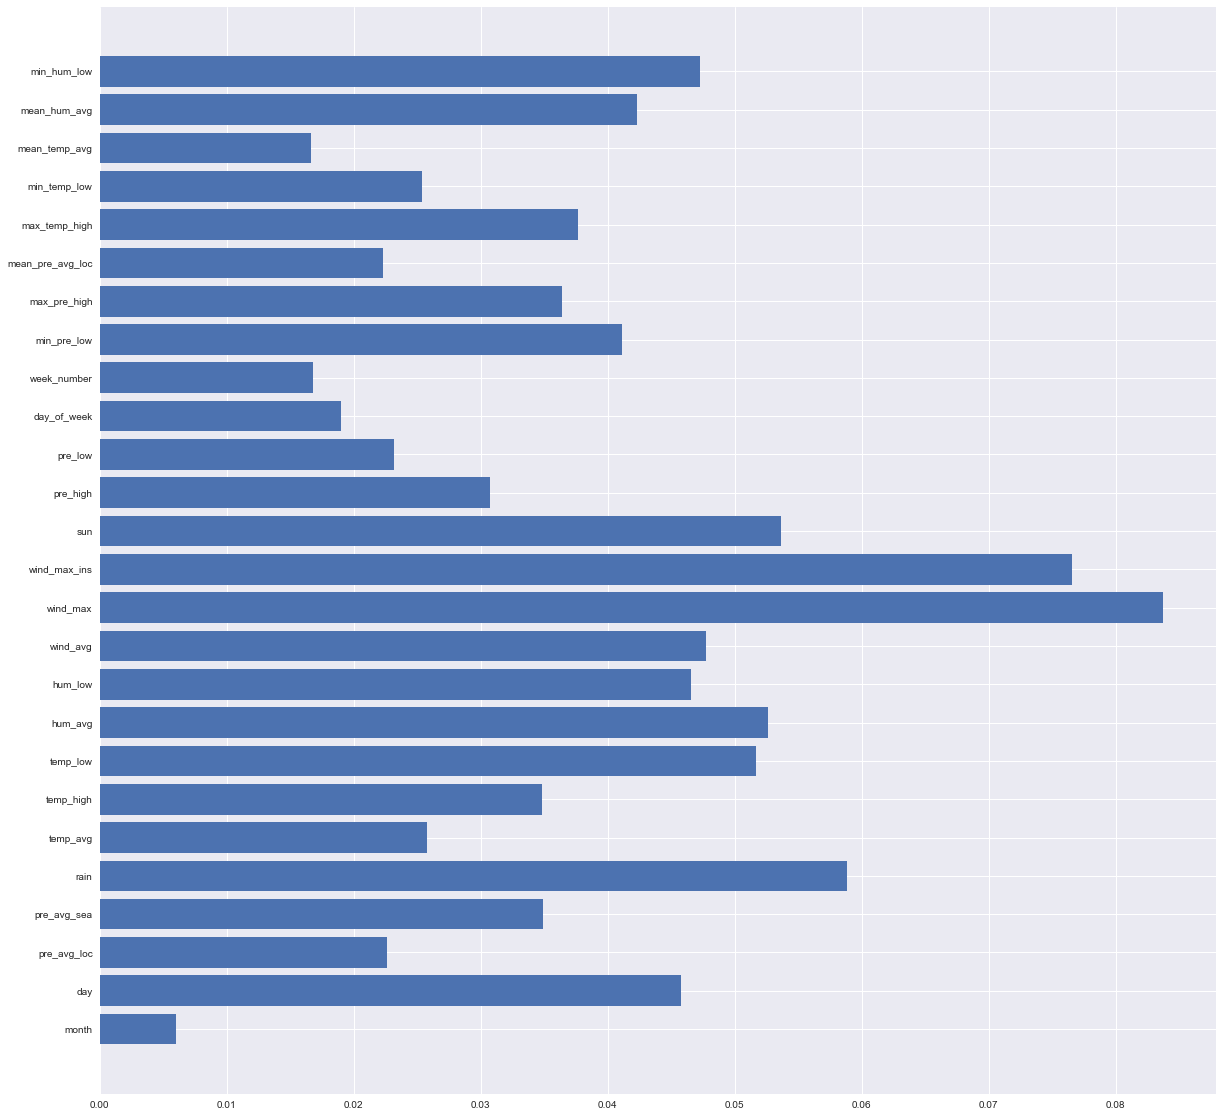

In [36]:
plt.figure(figsize = (20 ,20))
plt.barh(range(len(random_forest.feature_importances_)), random_forest.feature_importances_)
plt.yticks(range(len(random_forest.feature_importances_)), X.columns.values)

---

## Plan2
- 前日、前々日差を追加

In [37]:
df3 = df.groupby("date", as_index=False)["px"].sum()

for i in df.columns[(df.columns!="px") & (df.columns!="hos") & (df.columns!="date")]:
    tmp = df.groupby("date", as_index=False)[i].mean()
    df3 = pd.merge(df3, tmp, how='left', on=['date']) 

In [38]:
df3.loc[df3["px"]>2,"px"] = 2

In [39]:
tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['pre_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["min_pre_low"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['pre_high'].max()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["max_pre_high"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['pre_avg_loc'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["mean_pre_avg_loc"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['temp_high'].max()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["max_temp_high"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['temp_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["min_temp_low"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['temp_avg'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["mean_temp_avg"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['hum_avg'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["mean_hum_avg"] = np.array(tmplist)[:len(df3)]

tmp = df3.groupby([pd.Grouper(freq='W', key='date')])['hum_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df3["min_hum_low"] = np.array(tmplist)[:len(df3)]

- 一日中最大最小差
- 前日最大最小差
- 前々日最大最小差
- 三日前最大最小差

In [40]:
df3["diff_pre"] = df3["pre_high"]-df3["pre_low"]
df3["diff_temp"] = df3["temp_high"]-df3["temp_low"]

In [41]:
df3["diff_pre_1"] = pd.Series(np.insert(df3["pre_high"].values[1:]-df3["pre_low"].values[:-1], 0, np.nan, axis=0))
df3["diff_pre_1_re"] = pd.Series(np.insert(df3["pre_low"].values[1:]-df3["pre_high"].values[:-1], 0, np.nan, axis=0))
df3["diff_pre_2"] = pd.Series(np.insert(df3["pre_high"].values[2:]-df3["pre_low"].values[:-2], 0, [np.nan,np.nan], axis=0))
df3["diff_pre_2_re"] = pd.Series(np.insert(df3["pre_low"].values[2:]-df3["pre_high"].values[:-2], 0, [np.nan,np.nan], axis=0))
df3["diff_pre_3"] = pd.Series(np.insert(df3["pre_high"].values[3:]-df3["pre_low"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))
df3["diff_pre_3_re"] = pd.Series(np.insert(df3["pre_low"].values[3:]-df3["pre_high"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))

df3["diff_temp_1"] = pd.Series(np.insert(df3["temp_high"].values[1:]-df3["temp_low"].values[:-1], 0, np.nan, axis=0))
df3["diff_temp_1_re"] = pd.Series(np.insert(df3["temp_low"].values[1:]-df3["temp_high"].values[:-1], 0, np.nan, axis=0))
df3["diff_temp_2"] = pd.Series(np.insert(df3["temp_high"].values[2:]-df3["temp_low"].values[:-2], 0, [np.nan,np.nan], axis=0))
df3["diff_temp_2_re"] = pd.Series(np.insert(df3["temp_low"].values[2:]-df3["temp_high"].values[:-2], 0, [np.nan,np.nan], axis=0))
df3["diff_temp_3"] = pd.Series(np.insert(df3["temp_high"].values[3:]-df3["temp_low"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))
df3["diff_temp_3_re"] = pd.Series(np.insert(df3["temp_low"].values[3:]-df3["temp_high"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))

In [42]:
df3.head()

,date,px,year,month,day,pre_avg_loc,pre_avg_sea,rain,temp_avg,temp_high,...,diff_pre_2,diff_pre_2_re,diff_pre_3,diff_pre_3_re,diff_temp_1,diff_temp_1_re,diff_temp_2,diff_temp_2_re,diff_temp_3,diff_temp_3_re
0,2011-04-04,0,2011,4,4,1016.4,1020.5,0.0,10.3,17.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-05,0,2011,4,5,1019.8,1023.8,0.0,12.1,21.0,...,NaN,NaN,NaN,NaN,15.7,-12.6,NaN,NaN,NaN,NaN
2,2011-04-06,0,2011,4,6,1021.2,1025.2,0.0,14.3,22.1,...,8.6,-0.4,NaN,NaN,17.6,-15.4,16.8,-11.5,NaN,NaN
3,2011-04-07,1,2011,4,7,1018.4,1022.3,0.0,17.3,21.9,...,2.7,-5.4,5.6,-3.0,16.3,-9.7,17.4,-8.6,16.6,-4.7
4,2011-04-08,0,2011,4,8,1014.0,1018.0,24.0,14.9,16.4,...,-2.8,-11.2,-1.9,-9.2,4.0,-8.5,10.8,-8.7,11.9,-7.6


Drop NAN

In [43]:
df3 = df3.dropna()

In [44]:
df3 = df3.drop(["date","year"],axis=1)

In [45]:
X = df3.drop("px",axis=1)
y = df3["px"]

In [46]:
X.columns

Index(['month', 'day', 'pre_avg_loc', 'pre_avg_sea', 'rain', 'temp_avg',
       'temp_high', 'temp_low', 'hum_avg', 'hum_low', 'wind_avg', 'wind_max',
       'wind_max_ins', 'sun', 'pre_high', 'pre_low', 'day_of_week',
       'week_number', 'min_pre_low', 'max_pre_high', 'mean_pre_avg_loc',
       'max_temp_high', 'min_temp_low', 'mean_temp_avg', 'mean_hum_avg',
       'min_hum_low', 'diff_pre', 'diff_temp', 'diff_pre_1', 'diff_pre_1_re',
       'diff_pre_2', 'diff_pre_2_re', 'diff_pre_3', 'diff_pre_3_re',
       'diff_temp_1', 'diff_temp_1_re', 'diff_temp_2', 'diff_temp_2_re',
       'diff_temp_3', 'diff_temp_3_re'],
      dtype='object')

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=random_state)

modeling

In [48]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = lgb.LGBMRegressor(learning_rate=0.05)

model_cv = GridSearchCV(model, {'min_child_weight':[0.001,0.01,0.0001],'subsample_freq':[1,3,5],'reg_alpha':[0.0,0.1,0.3],'reg_lambda':[0.0,0.1,0.3]}, verbose=1)
model_cv.fit(X_train, y_train)
print(model_cv.best_params_)

"""params = {
    'random_state': random_state,
    'colsample_bytree': 1, 
    'min_child_samples': 10, 
    'num_leaves': 50, 
    'subsample': 0.5
}"""

model = lgb.LGBMRegressor(**model_cv.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'min_child_weight': 0.001, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'subsample_freq': 1}


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:    5.8s finished


In [49]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.29332672456557041

In [50]:
result = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})

In [51]:
result.groupby(['actual']).mean()

,pred
actual,
0,0.308215
1,0.374263
2,0.429413


In [52]:
# result.to_csv('result2.csv', index=False)

In [53]:
from scipy import stats
stats.ttest_ind(result[result["actual"]==0]["pred"].values, result[(result["actual"]==1) | (result["actual"]==2)]["pred"].values, equal_var=False)

Ttest_indResult(statistic=-4.8370167798012789, pvalue=3.1360233770845569e-06)

In [54]:
stats.f_oneway(result[result["actual"]==0]["pred"].values, result[result["actual"]==1]["pred"].values, result[result["actual"]==2]["pred"].values)

F_onewayResult(statistic=16.144878322387157, pvalue=1.7814759389381068e-07)

RandomForest

In [55]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [56]:
random_forest.feature_importances_

array([ 0.00517297,  0.02526764,  0.01524404,  0.01925296,  0.03538172,
        0.01682032,  0.01167681,  0.01829437,  0.03840368,  0.02422908,
        0.02971329,  0.04746306,  0.03818446,  0.03594807,  0.01095018,
        0.02422713,  0.01045969,  0.01680099,  0.03067826,  0.03113711,
        0.00873591,  0.0212017 ,  0.0086089 ,  0.00925535,  0.02034466,
        0.04087794,  0.03511069,  0.01983879,  0.03134877,  0.03332171,
        0.02476662,  0.02104049,  0.03913504,  0.02434066,  0.02767188,
        0.03745349,  0.02902031,  0.02555927,  0.03175902,  0.02530297])

([<matplotlib.axis.YTick at 0x20c6b7ba978>,
 <a list of 40 Text yticklabel objects>)

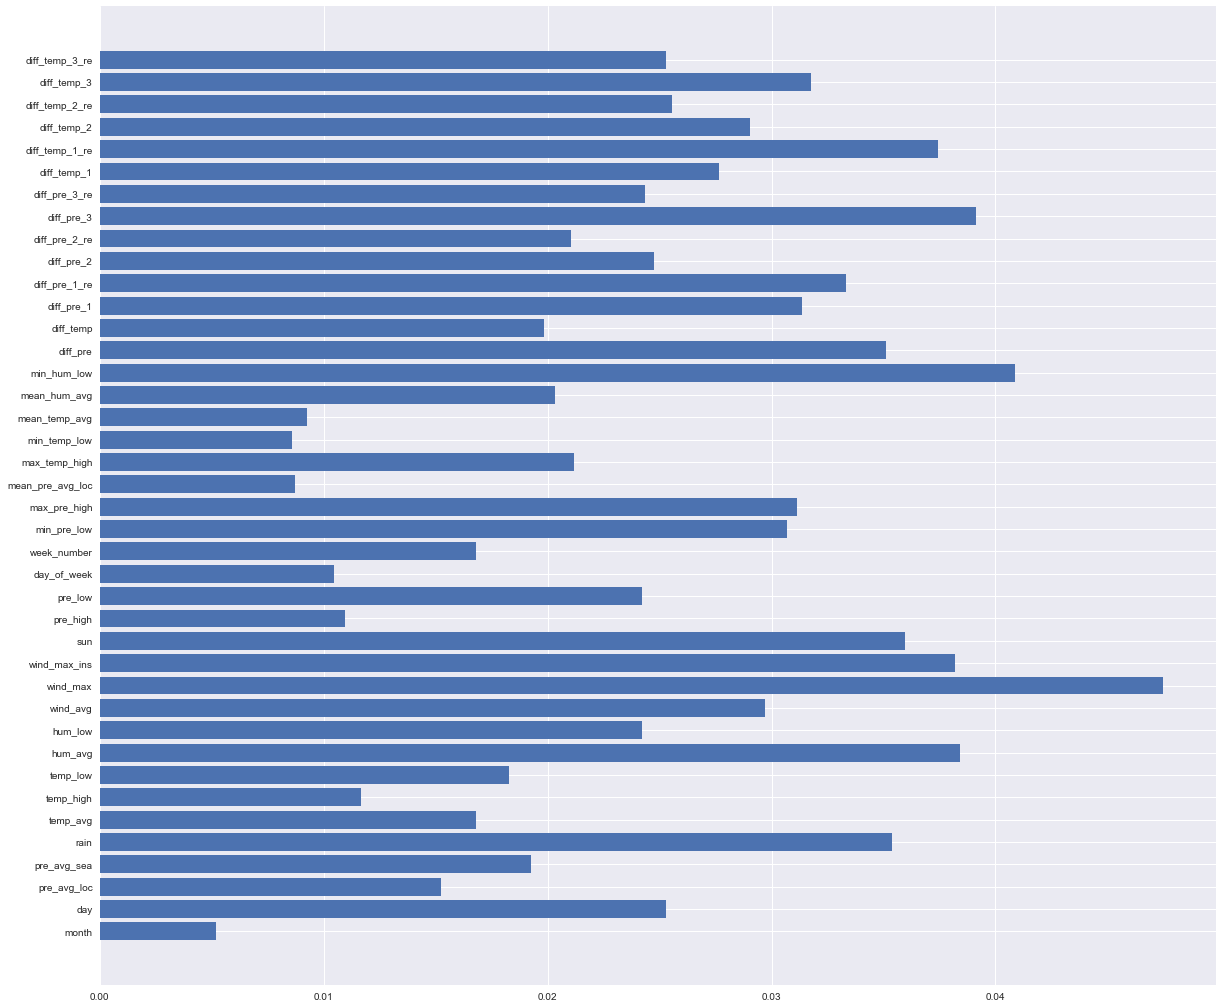

In [57]:
plt.figure(figsize = (20 ,18))
plt.barh(range(len(random_forest.feature_importances_)), random_forest.feature_importances_)
plt.yticks(range(len(random_forest.feature_importances_)), X.columns.values)

---

## Plan3
- 気圧要因のみ

In [58]:
df3.columns

Index(['px', 'month', 'day', 'pre_avg_loc', 'pre_avg_sea', 'rain', 'temp_avg',
       'temp_high', 'temp_low', 'hum_avg', 'hum_low', 'wind_avg', 'wind_max',
       'wind_max_ins', 'sun', 'pre_high', 'pre_low', 'day_of_week',
       'week_number', 'min_pre_low', 'max_pre_high', 'mean_pre_avg_loc',
       'max_temp_high', 'min_temp_low', 'mean_temp_avg', 'mean_hum_avg',
       'min_hum_low', 'diff_pre', 'diff_temp', 'diff_pre_1', 'diff_pre_1_re',
       'diff_pre_2', 'diff_pre_2_re', 'diff_pre_3', 'diff_pre_3_re',
       'diff_temp_1', 'diff_temp_1_re', 'diff_temp_2', 'diff_temp_2_re',
       'diff_temp_3', 'diff_temp_3_re'],
      dtype='object')

In [59]:
df4 = df3.drop(['month', 'day', 'rain', 'temp_avg',
       'temp_high', 'temp_low', 'hum_avg', 'hum_low', 'wind_avg', 'wind_max',
       'wind_max_ins', 'sun', 'day_of_week',
       'week_number', 'max_temp_high', 'min_temp_low', 'mean_temp_avg', 'mean_hum_avg',
       'min_hum_low', 'diff_temp',
       'diff_temp_1', 'diff_temp_1_re', 'diff_temp_2', 'diff_temp_2_re',
       'diff_temp_3', 'diff_temp_3_re'],axis=1)

In [60]:
df4.columns

Index(['px', 'pre_avg_loc', 'pre_avg_sea', 'pre_high', 'pre_low',
       'min_pre_low', 'max_pre_high', 'mean_pre_avg_loc', 'diff_pre',
       'diff_pre_1', 'diff_pre_1_re', 'diff_pre_2', 'diff_pre_2_re',
       'diff_pre_3', 'diff_pre_3_re'],
      dtype='object')

In [61]:
X = df4.drop("px",axis=1)
y = df4["px"]

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=random_state)

In [63]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = lgb.LGBMRegressor(learning_rate=0.05)

model_cv = GridSearchCV(model, {'min_child_weight':[0.001,0.01,0.0001],'subsample_freq':[1,3,5],'reg_alpha':[0.0,0.1,0.3],'reg_lambda':[0.0,0.1,0.3]}, verbose=1)
model_cv.fit(X_train, y_train)
print(model_cv.best_params_)

"""params = {
    'random_state': random_state,
    'colsample_bytree': 1, 
    'min_child_samples': 10, 
    'num_leaves': 50, 
    'subsample': 0.5
}"""

model = lgb.LGBMRegressor(**model_cv.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'min_child_weight': 0.001, 'reg_alpha': 0.0, 'reg_lambda': 0.3, 'subsample_freq': 1}


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:    3.1s finished


In [64]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.3129328547035321

In [65]:
result = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})

In [66]:
result.groupby(['actual']).mean()

,pred
actual,
0,0.321919
1,0.341134
2,0.378490


In [67]:
from scipy import stats
stats.ttest_ind(result[result["actual"]==0]["pred"].values, result[(result["actual"]==1) | (result["actual"]==2)]["pred"].values, equal_var=False)

Ttest_indResult(statistic=-2.1663669838124076, pvalue=0.031534147746899881)

In [68]:
stats.f_oneway(result[result["actual"]==0]["pred"].values, result[result["actual"]==1]["pred"].values, result[result["actual"]==2]["pred"].values)

F_onewayResult(statistic=3.2682368576483398, pvalue=0.039067734624898647)

---

- 気圧、気温要因のみ

In [69]:
df5 = df3.loc[:, ['px', 'pre_avg_loc', 'pre_avg_sea', 'temp_avg',
       'temp_high', 'temp_low', 'pre_high', 'pre_low', 'min_pre_low', 'max_pre_high', 'mean_pre_avg_loc',
       'max_temp_high', 'min_temp_low', 'mean_temp_avg', 'mean_hum_avg',
       'min_hum_low', 'diff_pre', 'diff_temp', 'diff_pre_1', 'diff_pre_1_re',
       'diff_pre_2', 'diff_pre_2_re', 'diff_pre_3', 'diff_pre_3_re',
       'diff_temp_1', 'diff_temp_1_re', 'diff_temp_2', 'diff_temp_2_re',
       'diff_temp_3', 'diff_temp_3_re']]

In [70]:
df5.columns

Index(['px', 'pre_avg_loc', 'pre_avg_sea', 'temp_avg', 'temp_high', 'temp_low',
       'pre_high', 'pre_low', 'min_pre_low', 'max_pre_high',
       'mean_pre_avg_loc', 'max_temp_high', 'min_temp_low', 'mean_temp_avg',
       'mean_hum_avg', 'min_hum_low', 'diff_pre', 'diff_temp', 'diff_pre_1',
       'diff_pre_1_re', 'diff_pre_2', 'diff_pre_2_re', 'diff_pre_3',
       'diff_pre_3_re', 'diff_temp_1', 'diff_temp_1_re', 'diff_temp_2',
       'diff_temp_2_re', 'diff_temp_3', 'diff_temp_3_re'],
      dtype='object')

In [71]:
X = df5.drop("px",axis=1)
y = df5["px"]

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=random_state)

In [73]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = lgb.LGBMRegressor(learning_rate=0.05)

model_cv = GridSearchCV(model, {'min_child_weight':[0.001,0.01,0.0001],'subsample_freq':[1,3,5],'reg_alpha':[0.0,0.1,0.3],'reg_lambda':[0.0,0.1,0.3]}, verbose=1)
model_cv.fit(X_train, y_train)
print(model_cv.best_params_)

"""params = {
    'random_state': random_state,
    'colsample_bytree': 1, 
    'min_child_samples': 10, 
    'num_leaves': 50, 
    'subsample': 0.5
}"""

model = lgb.LGBMRegressor(**model_cv.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'min_child_weight': 0.001, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample_freq': 1}


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:    4.0s finished


In [74]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.30362207442678363

In [75]:
result = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})

In [76]:
result.groupby(['actual']).mean()

,pred
actual,
0,0.315298
1,0.333164
2,0.428252


In [77]:
from scipy import stats
stats.ttest_ind(result[result["actual"]==0]["pred"].values, result[(result["actual"]==1) | (result["actual"]==2)]["pred"].values, equal_var=False)

Ttest_indResult(statistic=-2.8181045670735676, pvalue=0.0053984840593311366)

In [78]:
stats.f_oneway(result[result["actual"]==0]["pred"].values, result[result["actual"]==1]["pred"].values, result[result["actual"]==2]["pred"].values)

F_onewayResult(statistic=10.908951093099995, pvalue=2.4213566628324593e-05)

---

## まとめ

#### 違うクラス（0,1,2）間、予測値の平均差の検定

- 気圧要因のみ（三日前までの差、週間集計最大最小平均含み）
    - t検定のp-value：0.0315
    - 0.05水準で有意, 0.01水準で有意ではない

- 気圧、気温要因のみ（三日前までの差、週間集計最大最小平均含み）
    - t検定のp-value：0.00540
    - 0.01水準で有意, 0.005水準で有意ではない

- 全要因（三日前までの差、週間集計最大最小平均含み）
    - t検定のp-value：3.14e-06
    - 有意

#### 全要因で訓練後、予測の平均値：

In [51]:
result.groupby(['actual']).mean()

,pred
actual,
0,0.308215
1,0.374263
2,0.429413


#### その他

- 有意差であるが、実応用は難しいです。

- 関連しそうな要因を集め、一回分散分析してみたら、どうですか？
- 地域の差があるかもしれないので、異なる地域のデータを集めていただければ幸いです。
- CrossValidation, Stacking, Emsembleなど複数モデルにおける解析方法は使ってませんが、わずかな改善があるかもしれません。

---

追記：発病数（sum）ではなくて、発病率（sum/count）のはずです。
上記の解析は無意味です。

## Plan4
発病率から計算する

In [80]:
df6 = df.groupby("date", as_index=False)["px"].sum()
df6["px"] /= df.groupby("date")["px"].count().values
for i in df.columns[(df.columns!="px") & (df.columns!="hos") & (df.columns!="date")]:
    tmp = df.groupby("date", as_index=False)[i].mean()
    df6 = pd.merge(df6, tmp, how='left', on=['date']) 

In [81]:
tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['pre_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["min_pre_low"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['pre_high'].max()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["max_pre_high"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['pre_avg_loc'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["mean_pre_avg_loc"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['temp_high'].max()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["max_temp_high"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['temp_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["min_temp_low"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['temp_avg'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["mean_temp_avg"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['hum_avg'].mean()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["mean_hum_avg"] = np.array(tmplist)[:len(df6)]

tmp = df6.groupby([pd.Grouper(freq='W', key='date')])['hum_low'].min()
tmplist = []
for i in tmp:
    tmplist.extend([i]*7)
df6["min_hum_low"] = np.array(tmplist)[:len(df6)]

In [82]:
df6["diff_pre"] = df6["pre_high"]-df6["pre_low"]
df6["diff_temp"] = df6["temp_high"]-df6["temp_low"]

In [83]:
df6["diff_pre_1"] = pd.Series(np.insert(df6["pre_high"].values[1:]-df6["pre_low"].values[:-1], 0, np.nan, axis=0))
df6["diff_pre_1_re"] = pd.Series(np.insert(df6["pre_low"].values[1:]-df6["pre_high"].values[:-1], 0, np.nan, axis=0))
df6["diff_pre_2"] = pd.Series(np.insert(df6["pre_high"].values[2:]-df6["pre_low"].values[:-2], 0, [np.nan,np.nan], axis=0))
df6["diff_pre_2_re"] = pd.Series(np.insert(df6["pre_low"].values[2:]-df6["pre_high"].values[:-2], 0, [np.nan,np.nan], axis=0))
df6["diff_pre_3"] = pd.Series(np.insert(df6["pre_high"].values[3:]-df6["pre_low"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))
df6["diff_pre_3_re"] = pd.Series(np.insert(df6["pre_low"].values[3:]-df6["pre_high"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))

df6["diff_temp_1"] = pd.Series(np.insert(df6["temp_high"].values[1:]-df6["temp_low"].values[:-1], 0, np.nan, axis=0))
df6["diff_temp_1_re"] = pd.Series(np.insert(df6["temp_low"].values[1:]-df6["temp_high"].values[:-1], 0, np.nan, axis=0))
df6["diff_temp_2"] = pd.Series(np.insert(df6["temp_high"].values[2:]-df6["temp_low"].values[:-2], 0, [np.nan,np.nan], axis=0))
df6["diff_temp_2_re"] = pd.Series(np.insert(df6["temp_low"].values[2:]-df6["temp_high"].values[:-2], 0, [np.nan,np.nan], axis=0))
df6["diff_temp_3"] = pd.Series(np.insert(df6["temp_high"].values[3:]-df6["temp_low"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))
df6["diff_temp_3_re"] = pd.Series(np.insert(df6["temp_low"].values[3:]-df6["temp_high"].values[:-3], 0, [np.nan,np.nan,np.nan], axis=0))

In [84]:
df6 = df6.dropna()

In [85]:
df6.columns

Index(['date', 'px', 'year', 'month', 'day', 'pre_avg_loc', 'pre_avg_sea',
       'rain', 'temp_avg', 'temp_high', 'temp_low', 'hum_avg', 'hum_low',
       'wind_avg', 'wind_max', 'wind_max_ins', 'sun', 'pre_high', 'pre_low',
       'day_of_week', 'week_number', 'min_pre_low', 'max_pre_high',
       'mean_pre_avg_loc', 'max_temp_high', 'min_temp_low', 'mean_temp_avg',
       'mean_hum_avg', 'min_hum_low', 'diff_pre', 'diff_temp', 'diff_pre_1',
       'diff_pre_1_re', 'diff_pre_2', 'diff_pre_2_re', 'diff_pre_3',
       'diff_pre_3_re', 'diff_temp_1', 'diff_temp_1_re', 'diff_temp_2',
       'diff_temp_2_re', 'diff_temp_3', 'diff_temp_3_re'],
      dtype='object')

In [86]:
df6 = df6.drop(["date","year"],axis=1)

In [87]:
#df6.loc[df6["px"]!=0,"px"] = 1

In [88]:
X = df6.drop("px",axis=1)
y = df6["px"]

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=random_state)

In [90]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model = lgb.LGBMRegressor(learning_rate=0.05)

model_cv = GridSearchCV(model, {'min_child_weight':[0.001,0.01,0.0001],'subsample_freq':[1,3,5],'reg_alpha':[0.0,0.1,0.3],'reg_lambda':[0.0,0.1,0.3]}, verbose=1)
model_cv.fit(X_train, y_train)
print(model_cv.best_params_)

"""params = {
    'random_state': random_state,
    'colsample_bytree': 1, 
    'min_child_samples': 10, 
    'num_leaves': 50, 
    'subsample': 0.5
}"""

model = lgb.LGBMRegressor(**model_cv.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'min_child_weight': 0.001, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'subsample_freq': 1}


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:    4.6s finished


In [91]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.048270903062959621

In [92]:
result = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})

In [93]:
#result.to_csv('result3.csv', index=False)

In [94]:
result.groupby(['actual']).mean()

,pred
actual,
0.000000,0.109267
0.142857,0.103063
0.166667,0.103761
0.200000,0.096236
0.250000,0.103256
0.285714,0.107934
0.333333,0.115084
0.400000,0.106418
0.500000,0.091159


In [95]:
from scipy import stats
stats.ttest_ind(result[result["actual"]==0]["pred"].values, result[(result["actual"]!=0)]["pred"].values, equal_var=False)

Ttest_indResult(statistic=0.57535346525683162, pvalue=0.5657976702700106)

発病率から計算すると、関係がないことです。